In [127]:
!pip install --user --upgrade --editable ms-1

Obtaining file:///X:/Reinforcement%20Learning/CS698R-ROMIT-MOHANTY-190720-MIDSEM/ms-1
  Attempting uninstall: ms-1
    Found existing installation: ms-1 1.0.0
    Uninstalling ms-1-1.0.0:
      Successfully uninstalled ms-1-1.0.0
  Running setup.py develop for ms-1


In [128]:
import gym
import numpy as np
import math
import random
from matplotlib import pyplot as plt
random.seed(3)
np.random.seed(3)
params={}
params["gamma"]=0.99
params["goInDirection"]=0.8
params["livingCost"]=0.04
params["startState"]=8
params["theta"]=pow(10,-4)
params["S+"]=[0,1,2,3,4,6,7,8,9,10,11]
params["S"]=[0,1,2,4,6,8,9,10,11]
params["A"]=[0,1,2,3]
gamma=params["gamma"]
env=gym.make('ms_1:RandomMaze-v0',params=params)
env.reset()
done= False
noEpisodes=500
n=3
lamda=0.3

In [129]:
pi=np.zeros(12)
pi[0]=2
pi[1]=2
pi[2]=2
pi[3]=10 #taken any random number
pi[4]=1
pi[5]=10 #taken any random number
pi[6]=1
pi[7]=10 #taken any random number
pi[8]=1
pi[9]=2
pi[10]=1
pi[11]=0

In [130]:
def generateTrajectory(env, policy,maxSteps):
    
    list_exp_tuples=[]
    done=False
    for i in range (maxSteps):
        exp_tuples = np.zeros((4))
        exp_tuples[0]=env.currState()
        exp_tuples[1]=policy[env.currState()]
        end_state, reward, done, info=env.step(policy[env.currState()])
        exp_tuples[2]=end_state
        exp_tuples[3]=reward
        # print(done)
        list_exp_tuples.append(exp_tuples)
        if done==True:
            break
    if done==False:
        list_exp_tuples=[]
    return np.array(list_exp_tuples)
np.random.seed(10)
random.seed(10)
env.reset()
print(generateTrajectory(env,pi,100))

[[ 8.    1.    4.   -0.04]
 [ 4.    1.    4.   -0.04]
 [ 4.    1.    0.   -0.04]
 [ 0.    2.    1.   -0.04]
 [ 1.    2.    2.   -0.04]
 [ 2.    2.    3.    1.  ]]


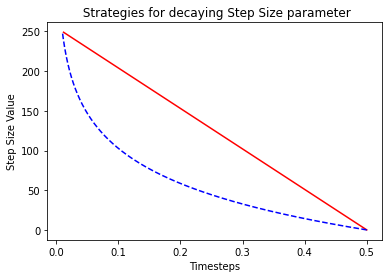

In [131]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType):
    step_size=np.zeros(maxSteps)
    if decayType=="Linear":
        decayRate=(initialValue-finalValue)/maxSteps
        for i in range(maxSteps):
            step_size[i]=initialValue-i*decayRate
        # plt.plot(np.arange(0,maxSteps),step_size, color='r')
        # plt.ylabel('Step_size Parameter w.r.t time')  
        # plt.xlabel('Timesteps') 
        # plt.title('Linear Decay of step size parameter') 
        # plt.savefig('Linear Decay of step size parameter.pdf') 
        # plt.close()
    if decayType=="Exp":
        decayRate=(np.log(initialValue/finalValue))/maxSteps
        step_size[0]=initialValue
        for i in range(maxSteps-1):
            step_size[i+1]=step_size[i]*np.exp(-decayRate)
        # plt.plot(np.arange(0,maxSteps),step_size, color='r')
        # plt.ylabel('Step_size Parameter w.r.t time')  
        # plt.xlabel('Timesteps') 
        # plt.title('Exponential Decay of step size parameter') 
        # plt.savefig('Exponential Decay of step size parameter.pdf') 
        # plt.close()
    return step_size
lin_x=decayAlpha(0.5,0.01,250,"Linear")
exp_x=decayAlpha(0.5,0.01,250,"Exp")
plt.plot(lin_x,np.arange(250),color='red',linestyle='-')
plt.plot(exp_x,np.arange(250),color='blue',linestyle='--')
plt.xlabel('Timesteps')
plt.ylabel('Step Size Value')
plt.title(' Strategies for decaying Step Size parameter')
plt.savefig('Decay Step Size.pdf')

In [132]:
alpha=(decayAlpha(0.5,0.01,250,"Exp"))
for i in range(250):
    alpha = np.append(alpha,0.01)

In [133]:
def MonteCarloPrediction(env, policy, gamma, alpha, maxSteps, noEpisodes, firstVisit):
    v=np.zeros(env.observation_space.n)
    v_r=np.zeros((noEpisodes,env.observation_space.n))
    Gt=np.zeros(noEpisodes)
    for e in range(noEpisodes):
        env.reset()
        t=generateTrajectory(env, policy,maxSteps)
        # print(t[0][3])
        vis=np.zeros(env.observation_space.n)
        # print(t)
        for i in range(len(t)):
            s=t[i][0]
            # print(s)
            # print(len(vis))
            if vis[int(s)] and firstVisit:
                continue
            G=0
            # print(i,np.shape(t), np.size(t,axis=0))
            for j in range(i,len(t)):
                # print(np.shape(t))
                # print(j)
                G+=(pow(gamma,j-i)*t[j,3])
            if s==4:
                Gt[e]=G
            # print(e)
            v[int(s)]=v[int(s)]+alpha[int(e)]*(G-v[int(s)])
            vis[int(s)]=1
        
        v_r[e]=v
    return v, v_r,Gt

In [134]:
def TemporalDifferencePrediction(env, policy, gamma , alpha, noEpisodes):
    v = np.zeros(env.observation_space.n)
    v_r = np.zeros((noEpisodes,env.observation_space.n))
    Gt=np.zeros(noEpisodes)
    for e in range(noEpisodes):
        s,done = env.reset()
        while not done:
            action=policy[s]
            next_state,reward,done,info = env.step(action)
            td_target = reward
            if not done:
                td_target = td_target + gamma*v[next_state]
            if s==4:
                Gt[e]=td_target
            td_error = td_target-v[s]

            v[s] = v[s] + alpha[e]*td_error
            s = next_state
        v_r[e] = v
    return v,v_r,Gt    

In [135]:
def generateNStepTrajectory(env, policy,n):
    
    list_exp_tuples=[]
    done=False
    for i in range (n):
        exp_tuples = np.zeros((4))
        exp_tuples[0]=env.currState()
        exp_tuples[1]=policy[env.currState()]
        end_state, reward, done, info=env.step(policy[env.currState()])
        exp_tuples[2]=end_state
        exp_tuples[3]=reward
        # print(done)
        list_exp_tuples.append(exp_tuples)
        if done==True:
            break
    return np.array(list_exp_tuples),env.currState(),done

In [136]:
def calculateReturn(gamma,path,n):
    g_partial=0
    for i in range(len(path)):
        g_partial+=(path[i][3]*pow(gamma,i))
    return g_partial

In [137]:
def nStepTD(env,pi,gamma,alpha,n,noEpisodes):
    v = np.zeros(env.observation_space.n)
    v_r = np.zeros((noEpisodes,env.observation_space.n))
    for e in range (noEpisodes):
        s,done=env.reset()
        path=[]
        while not done and path is not None:
            path,s_next,done=generateNStepTrajectory(env,pi,n)
            g_partial=calculateReturn(gamma,path,n)
            if not done:
                target=g_partial+pow(gamma,n)*v[s_next]
            ntd_error=target-v[s]
            v[s]=v[s]+alpha[e]*ntd_error
            if len(path)==1 and done:
                path = None
            s=s_next
        v_r[e]=v
    return v,v_r

In [138]:
def TDlamda(env,pi,gamma,alpha,lamda,noEpisodes):
    v = np.zeros(env.observation_space.n)
    v_r = np.zeros((noEpisodes,env.observation_space.n))
    E=np.zeros(env.observation_space.n)
    for e in range(noEpisodes):
        s,done=env.reset()
        # if e==100:
            
        while not done:
            a=pi[s]
            s_next,r,done,info=env.step(a)
            td_target=r
            if not done:
                td_target=td_target+gamma*v[s_next]
            td_error=td_target-v[s]
            E[s]+=1
            v=v+alpha[e]*td_error*E
            E=gamma*lamda*E
            s=s_next
        v_r[e]=v 
    return v,v_r

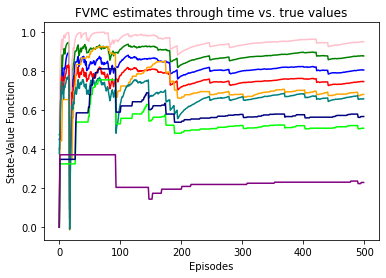

In [139]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt= MonteCarloPrediction(env, pi, gamma, alpha, 1000, 500, 1)
x = np.arange(0,500)
o=np.ones(500)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("FVMC estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-8.pdf")

plt.show()
plt.close()

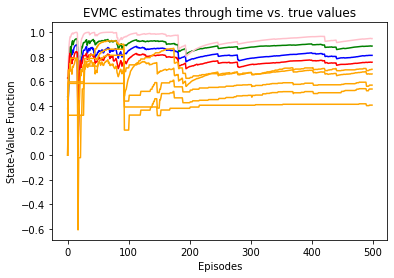

In [140]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt = MonteCarloPrediction(env, pi, gamma, alpha, 1000,500, 0)
x = np.arange(0,500)
o=np.ones(500)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("EVMC estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-9.pdf")

plt.show()
plt.close()

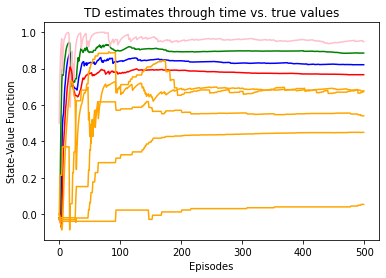

In [141]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt = TemporalDifferencePrediction(env, pi, gamma , alpha, 500)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("TD estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-10.pdf")

plt.show()
plt.close()

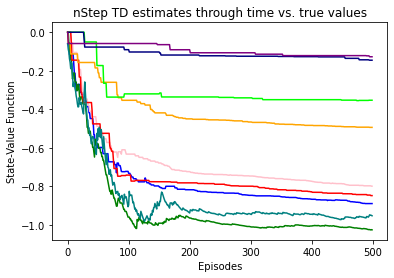

In [142]:
random.seed(10)
np.random.seed(10)
v,v_r2 = nStepTD(env,pi,gamma,alpha,n,noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("nStep TD estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-11.pdf")

plt.show()
plt.close()

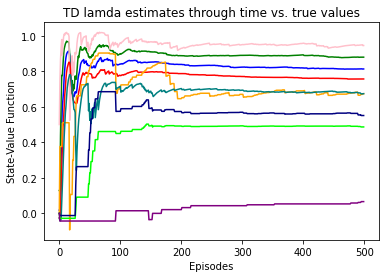

In [143]:
random.seed(10)
np.random.seed(10)
v,v_r2 =TDlamda(env,pi,gamma,alpha,lamda,noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")/
plt.title("TD lamda estimates through time vs. true values")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-12.pdf")

plt.show()
plt.close()

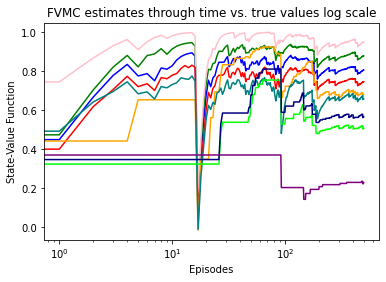

In [144]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt= MonteCarloPrediction(env, pi, gamma, alpha, 1000, 500, 1)
x = np.arange(0,500)
o=np.ones(500)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("FVMC estimates through time vs. true values log scale")
plt.xscale("log")
plt.xlabel("Episodes")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-14.pdf")

plt.show()
plt.close()

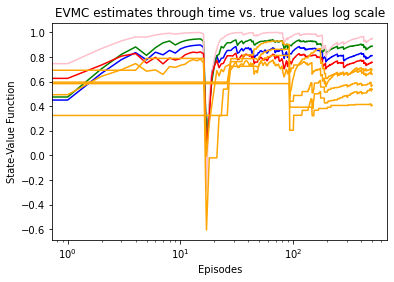

In [145]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt = MonteCarloPrediction(env, pi, gamma, alpha, 1000,500, 0)
x = np.arange(0,500)
o=np.ones(500)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("EVMC estimates through time vs. true values log scale")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-15.pdf")

plt.show()
plt.close()

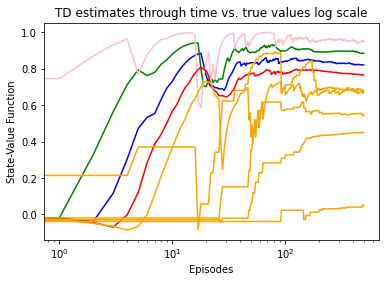

In [146]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt = TemporalDifferencePrediction(env, pi, gamma , alpha, 500)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("TD estimates through time vs. true values log scale")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-16.pdf")

plt.show()
plt.close()

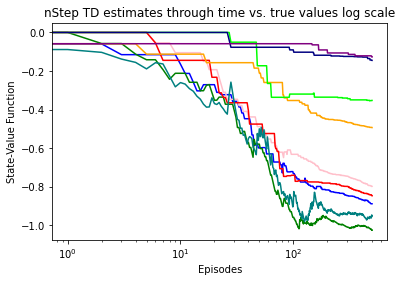

In [147]:
random.seed(10)
np.random.seed(10)
v,v_r2 = nStepTD(env,pi,gamma,alpha,n,noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("nStep TD estimates through time vs. true values log scale")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-17.pdf")

plt.show()
plt.close()

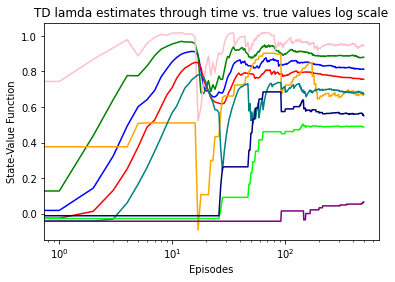

In [148]:
random.seed(10)
np.random.seed(10)
v,v_r2 =TDlamda(env,pi,gamma,alpha,lamda,noEpisodes)
x = np.arange(0,noEpisodes)
o=np.ones(noEpisodes)
plt.plot(x,v_r2[:,0],color = 'blue')
# plt.plot(x,5/6*o,color = 'blue',linestyle = "--")
plt.plot(x,v_r2[:,1],color = 'green')
# plt.plot(x,4/6*o,color = 'green',linestyle = "--")
plt.plot(x,v_r2[:,2],color = 'pink')
# plt.plot(x,3/6*o,color = 'pink',linestyle = "--")
plt.plot(x,v_r2[:,4],color = 'red')
# plt.plot(x,2/6*o,color = 'red',linestyle = "--")
plt.plot(x,v_r2[:,6],color = 'orange')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,8],color = 'teal')
# plt.plot(x,1/6*o,color = 'teal',linestyle = "--")
plt.plot(x,v_r2[:,9],color = 'lime')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,10],color = 'navy')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.plot(x,v_r2[:,11],color = 'purple')
# plt.plot(x,1/6*o,color = 'orange',linestyle = "--")
plt.title("TD lamda estimates through time vs. true values log scale")
plt.xlabel("Episodes")
plt.xscale("log")
plt.ylabel("State-Value Function")
# plt.legend(["V(1)", "V(","pink","red","orange"])
# plt.legend(bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.savefig("problem 2, Q-18.pdf")

plt.show()
plt.close()

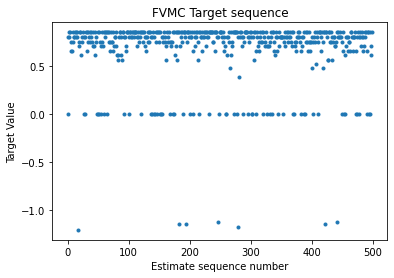

In [149]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt= MonteCarloPrediction(env, pi, gamma, alpha, 1000,500, 1)
# optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
# plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("FVMC Target sequence")
plt.savefig("prob2 Q-20.pdf")

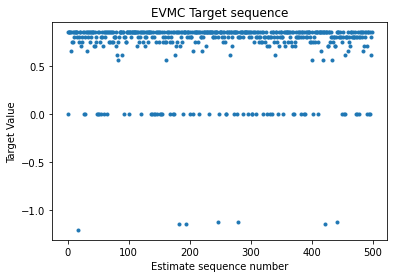

In [153]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt= MonteCarloPrediction(env, pi, gamma, alpha, 1000,500, 0)
# optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
# plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("EVMC Target sequence")
plt.savefig("prob2 Q-21.pdf")

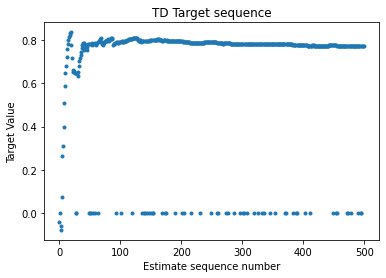

In [152]:
random.seed(10)
np.random.seed(10)
v,v_r2 ,Gt = TemporalDifferencePrediction(env, pi, gamma , alpha, 500)
# optVal=np.ones(noEpisodes)*3/6
x=np.arange(noEpisodes)
plt.plot(x,Gt,'.')
# plt.plot(x,optVal)
plt.xlabel("Estimate sequence number")
plt.ylabel("Target Value")
plt.title("TD Target sequence")
plt.savefig("prob2 Q-22.pdf")